# 📘 Forecasting Migration Flows - Model Interpretation and Scenario Analysis

**Author:** _Golib Sanaev_  
**Date:** _2025-09-23_  
**Last Updated:** _2025-10-09_  
**Project:** Forecasting Migration Flows with Machine Learning  

---

### 🎯 **Purpose**

To interpret model behavior, identify key drivers of migration, and explore forward-looking scenarios. This notebook builds on the trained models from ***03-feature-engineering-and-modeling*** and focuses on explainability and sensitivity analysis.

---

## 📑 Table of Contents

1. [Introduction and Objectives](#1-introduction-and-objectives)  
2. [Load Trained Model and Prepare Data](#2-load-trained-model-and-prepare-data)  
3. [Feature Importance: Global vs. Group-Level](#3-feature-importance-global-vs-group-level)  
4. [Model Interpretation with SHAP](#4-model-interpretation-with-shap)  
 4.1. [Global SHAP Values](#41-global-shap-values)  
 4.2. [Feature-Level Analysis](#42-feature-level-analysis)  
 4.3. [Dependence Plots](#43-dependence-plots)  
 4.4. [Regional SHAP Aggregation](#44-regional-shap-aggregation)  
 4.5. [Regional SHAP Heatmap](#45-regional-shap-heatmap)  
 4.6. [Local Explanations (Waterfall)](#46-local-explanations-waterfall)  
5. [Predictive Scenario Simulation](#5-predictive-scenario-simulation)  
 5.1. [Scenario Setup (Baseline vs. Shocks)](#51-scenario-setup-baseline-vs-shocks)  
 5.2. [Scenario Runner (Δ vs. Baseline)](#52-scenario-runner--vs-baseline)  
 5.3. [Regional Scenario Results](#53-regional-scenario-results)  
 5.4. [Top Movers and Country Examples](#54-top-movers-and-country-examples)  
6. [Visualization Enhancements](#6-visualization-enhancements)  
7. [Key Insights Summary](#7-key-insights-summary)  
8. [Next Steps](#8-next-steps)

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.inspection import permutation_importance
import random

plt.style.use("seaborn-v0_8-whitegrid")

# --- 1. Load Data and Model ---
df = pd.read_csv("../data/processed/countries_clean.csv")
model = joblib.load("../models/random_forest_model.pkl")

print(f"Data shape: {df.shape}")

# --- 2. Recreate All Features Exactly as in Notebook 03 ---

CAP = 50

# 2.1 Compute base migration indicators
if "net_migration_per_1000" not in df.columns:
    df["net_migration_per_1000"] = (df["net_migration"] / df["population"]) * 1000
df["is_crisis"] = (df["net_migration_per_1000"].abs() > CAP).astype(int)

# 2.2 Lag crisis flag by country
df = df.sort_values(["Country Name", "year"]).reset_index(drop=True)
df["is_crisis_lag1"] = (
    df.groupby("Country Name")["is_crisis"].shift(1).fillna(0).astype(int)
)

# 2.3 Urbanization rate (stable version)
df["urbanization_rate_stable"] = (
    (df["urban_pop_growth"] / df["pop_growth"].replace(0, np.nan))
    .clip(lower=-5, upper=5)
)

# 2.4 Interaction term
df["gdp_growth_x_urban"] = df["gdp_growth"] * df["urbanization_rate_stable"]

# 2.5 One-hot encode Region and IncomeGroup
cat_cols = [c for c in ["Region", "IncomeGroup"] if c in df.columns]
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Feature engineering complete — df_model shape: {df_model.shape}")


Data shape: (5712, 21)
Feature engineering complete — df_model shape: (5712, 33)


/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-migration-flows-ml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Trained Model and Features

In [2]:
# Load the same feature set used in 03
X_cols = joblib.load("../models/X_columns.pkl")

# Ensure columns match
X = df_model[X_cols].copy()
y = df_model["net_migration_per_1000"]

# Sanity check
print(f"Loaded model and features ({len(X_cols)} predictors)")

Loaded model and features (26 predictors)


## 3. Feature Importance: Global vs. Group-Level

> Compare feature importance overall and by income group to identify structural differences.  


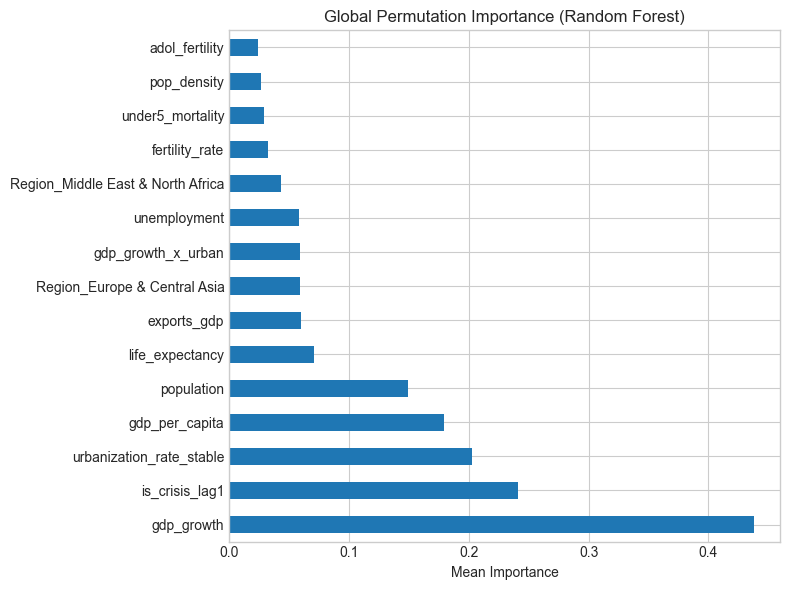

In [3]:
# Global importance

perm = permutation_importance(model, X, y, n_repeats=10, random_state=42)
imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

imp.head(15).plot(kind="barh", figsize=(8, 6))

plt.title("Global Permutation Importance (Random Forest)")
plt.xlabel("Mean Importance")
plt.tight_layout(); plt.show()

## 4. SHAP Explainability Analysis

### 4.1 Fast SHAP Setup (same 500-row sample, extra speed-ups)

> Uses check_additivity=False (safe for tree models) and float32 to cut compute/memory.  


In [4]:
# Fast SHAP Setup

# Sample remains 500 rows (matches your current approach)
X_sample = X.sample(n=500, random_state=42).astype(np.float32)  # float32 for speed/memory

# TreeExplainer (regression) – disable additivity check for speed on trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample, check_additivity=False)

# Keep handy objects
feature_names = list(X_sample.columns)
expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value


### 4.2 Global Feature Importance

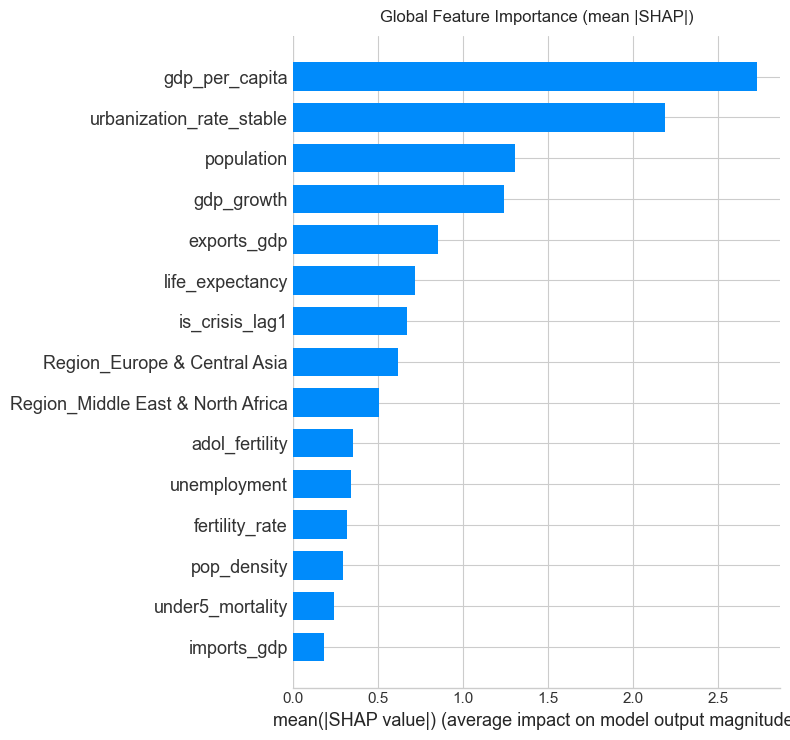

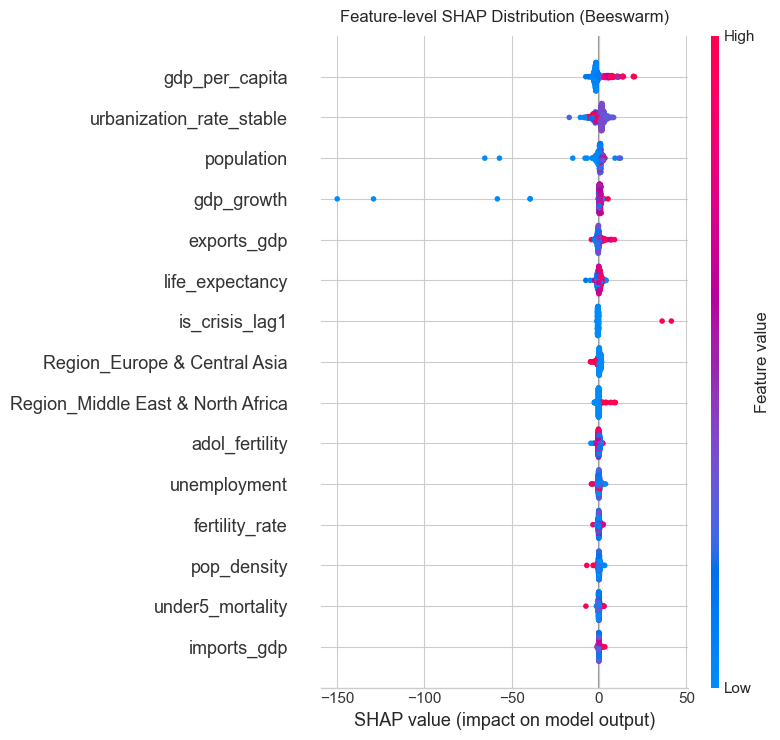

In [5]:
# Global Feature Importance

plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=15, show=False)
plt.title("Global Feature Importance (mean |SHAP|)", pad=10)
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values, X_sample, max_display=15, show=False)
plt.title("Feature-level SHAP Distribution (Beeswarm)", pad=10)
plt.tight_layout()
plt.show()


### 4.3 Feature-Level Explanations (rank + direction)

> A tidy table for report slides: top drivers by mean |SHAP| and the direction (sign of association via Spearman corr between feature and SHAP).

In [6]:
# Feature-Level Explanations (rank + direction)

# sv = pd.DataFrame(shap_values, columns=feature_names)
sv = pd.DataFrame(shap_values, columns=feature_names, index=X_sample.index)
abs_mean = sv.abs().mean().sort_values(ascending=False)

# Direction: correlation between feature values and SHAP values (Spearman is robust)
dirs = (
    pd.Series(
        {f: pd.Series(X_sample[f]).corr(sv[f], method="spearman") for f in feature_names}
    ).reindex(abs_mean.index)
)

top = (
    pd.DataFrame({
        "mean_|SHAP|": abs_mean,
        "direction_spearman": dirs
    })
    .round(4)
    .head(15)
)

display(top)


,mean_|SHAP|,direction_spearman
gdp_per_capita,2.7297,0.7932
urbanization_rate_stable,2.1909,-0.1458
population,1.3102,0.7888
gdp_growth,1.2421,0.6819
exports_gdp,0.8536,0.8212
life_expectancy,0.7214,0.8407
is_crisis_lag1,0.6731,0.1093
Region_Europe & Central Asia,0.6211,-0.7619
Region_Middle East & North Africa,0.5100,0.5420
adol_fertility,0.3572,-0.6756


> 📈 *Interpretation:* The **`direction_spearman`** column shows the correlation between each feature and its SHAP impact.  
> • Positive ( > 0 ) → higher feature values **increase** the predicted net migration.  
> • Negative (< 0 ) → higher values **decrease** it.


### 4.4 SHAP Dependence (with interactions)

> Two high-impact features with automatic interaction coloring (change feature names if your top list differs).  

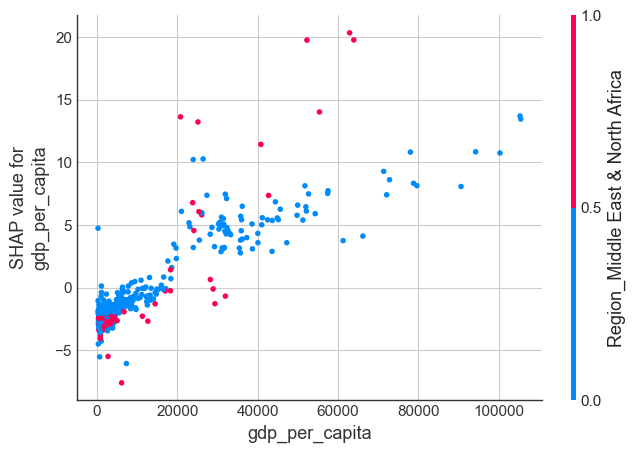

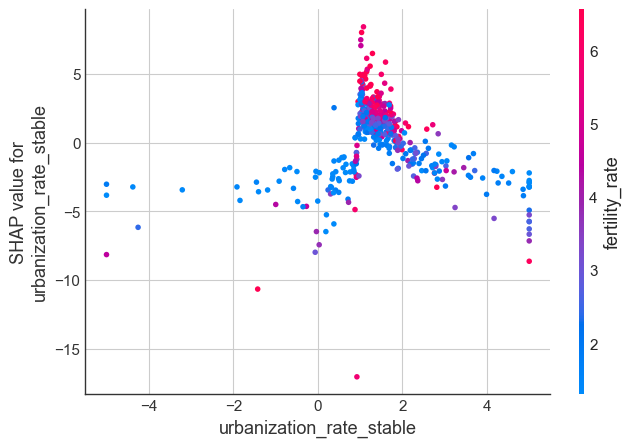

In [7]:
# SHAP Dependence Plots

top_features = list(top.index[:2])  # top 2 by mean |SHAP|
for f in top_features:
    shap.dependence_plot(
        f, shap_values, X_sample, interaction_index="auto", show=True
    )


### 4.5 Regional SHAP Heatmap (sensitivity by region)

> Your current “Regional Insights Dashboard” averages raw features by region; this variant aggregates **SHAP impact** by region to show **what** the model is using where. 

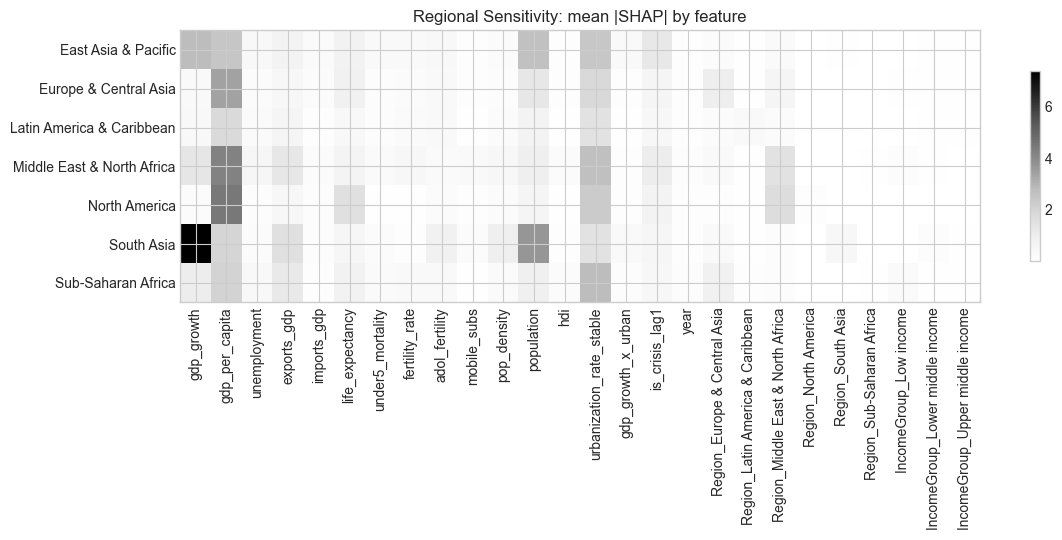

,Top 5 drivers
Region,
East Asia & Pacific,"[gdp_growth, population, gdp_per_capita, urban..."
Europe & Central Asia,"[gdp_per_capita, urbanization_rate_stable, pop..."
Latin America & Caribbean,"[gdp_per_capita, urbanization_rate_stable, pop..."
Middle East & North Africa,"[gdp_per_capita, urbanization_rate_stable, Reg..."
North America,"[gdp_per_capita, urbanization_rate_stable, Reg..."
South Asia,"[gdp_growth, population, gdp_per_capita, expor..."
Sub-Saharan Africa,"[urbanization_rate_stable, gdp_per_capita, exp..."


In [8]:
# Regional SHAP Heatmap (mean |SHAP| by region)

# Assumes df has a "Region" column; you used it earlier in the dashboard section.
sv_abs = sv.abs().copy()
sv_abs["Region"] = df.loc[X_sample.index, "Region"].values

region_shap = (
    sv_abs.groupby("Region", dropna=False)[feature_names]
    .mean()
    .sort_index()
)

# Plot a compact heatmap
fig, ax = plt.subplots(figsize=(min(12, 0.45*len(feature_names)+4), 0.5*len(region_shap)+2))
im = ax.imshow(region_shap.values, aspect="auto")

ax.set_yticks(range(len(region_shap.index)))
ax.set_yticklabels(region_shap.index)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)

ax.set_title("Regional Sensitivity: mean |SHAP| by feature")
fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

# Optional: top drivers per region in table form
top_per_region = (
    region_shap.apply(lambda r: r.sort_values(ascending=False).head(5).index.tolist(), axis=1)
    .rename("Top 5 drivers")
    .to_frame()
)
display(top_per_region)


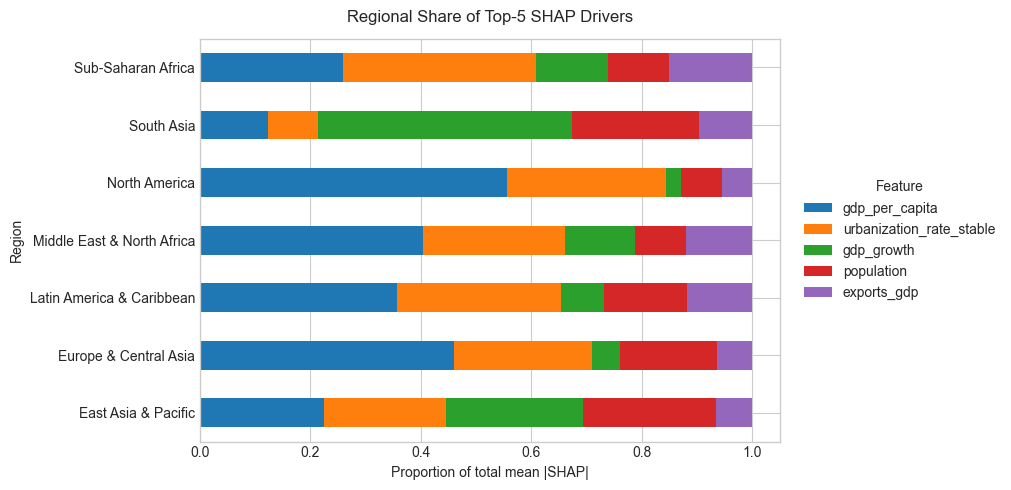

In [9]:
# Regional share of total mean |SHAP| for top 5 drivers
top_features = region_shap.mean().sort_values(ascending=False).head(5).index
region_share = region_shap[top_features].div(region_shap[top_features].sum(axis=1), axis=0)

ax = region_share.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 5),
    legend=True
)

plt.title("Regional Share of Top-5 SHAP Drivers", pad=12)
plt.xlabel("Proportion of total mean |SHAP|")
plt.tight_layout(rect=[0, 0, 0.8, 1])  # make room on the right side

# Move legend outside the plot area
plt.legend(
    title="Feature",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=False
)

plt.show()

### 4.6 Local Explanations (quick exemplars)


Waterfall for sample index 3904


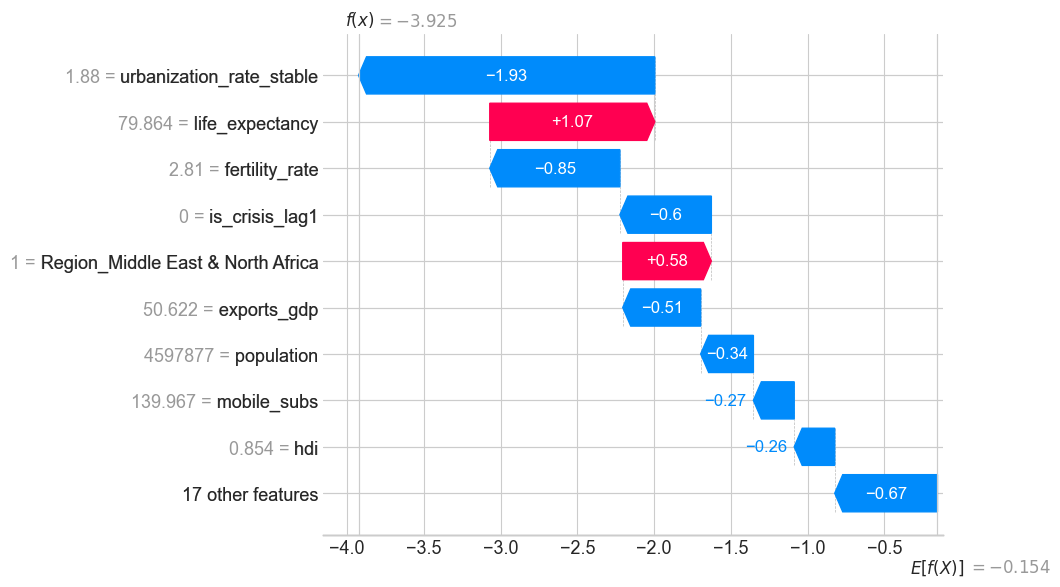


Waterfall for sample index 577


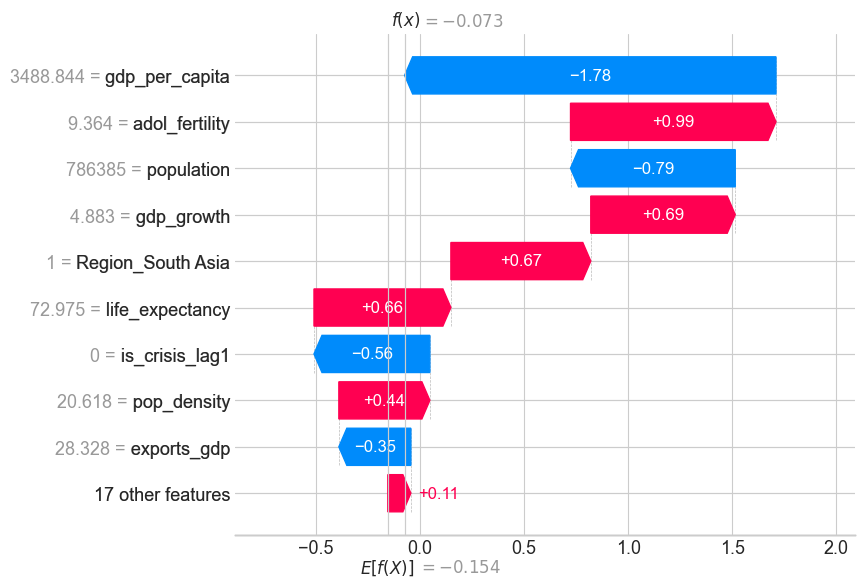


Waterfall for sample index 2209


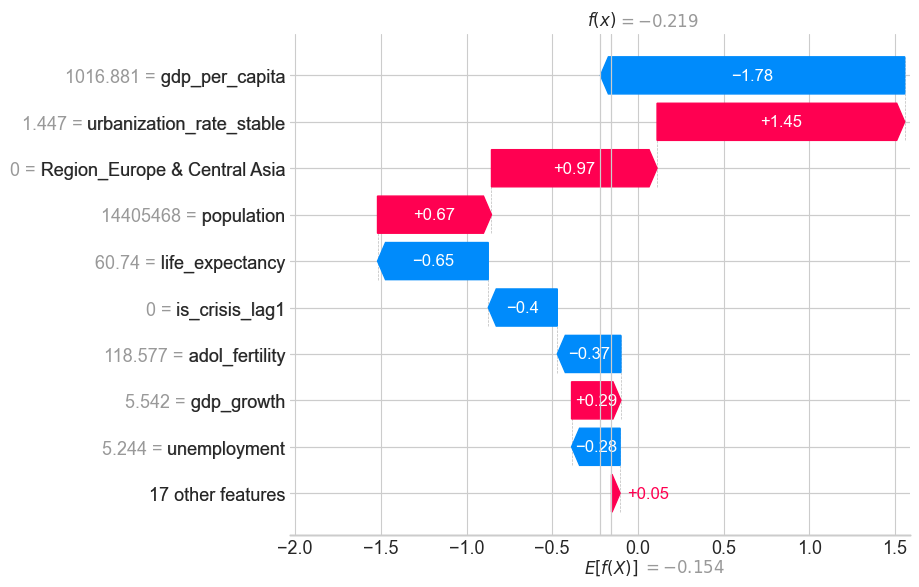

In [10]:
# Local Explanations (Waterfall for 3 cases)

expected_value_scalar = (
    explainer.expected_value[0]
    if isinstance(explainer.expected_value, (list, np.ndarray))
    else explainer.expected_value
)

# Reproducible random selection
import random
random.seed(42)
idxs = random.sample(list(X_sample.index), 3)

for i in idxs:
    print(f"\nWaterfall for sample index {i}")
    shap.plots.waterfall(
        shap.Explanation(
            values=sv.loc[i].values,
            base_values=expected_value_scalar,
            data=X_sample.loc[i],
            feature_names=feature_names
        )
    )


## 5. Scenario Simulation

### 5.1 Economic Growth Scenarios

> Test how simulated GDP growth affects predicted migration flows.    

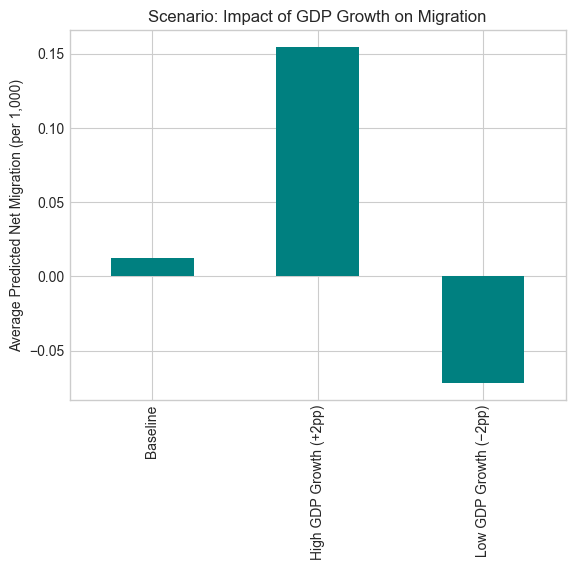

In [11]:
scenarios = {
    "Baseline": X.copy(),
    "High GDP Growth (+2pp)": X.assign(gdp_growth=X["gdp_growth"] + 2),
    "Low GDP Growth (−2pp)": X.assign(gdp_growth=X["gdp_growth"] - 2)
}

results = {}
for name, X_s in scenarios.items():
    preds = model.predict(X_s)
    results[name] = preds.mean()

pd.Series(results).plot(kind="bar", color="teal")
plt.title("Scenario: Impact of GDP Growth on Migration")
plt.ylabel("Average Predicted Net Migration (per 1,000)")
plt.show()

### 5.2 Demographic Change Scenarios

> Explore how fertility and life expectancy shifts impact migration trends.    

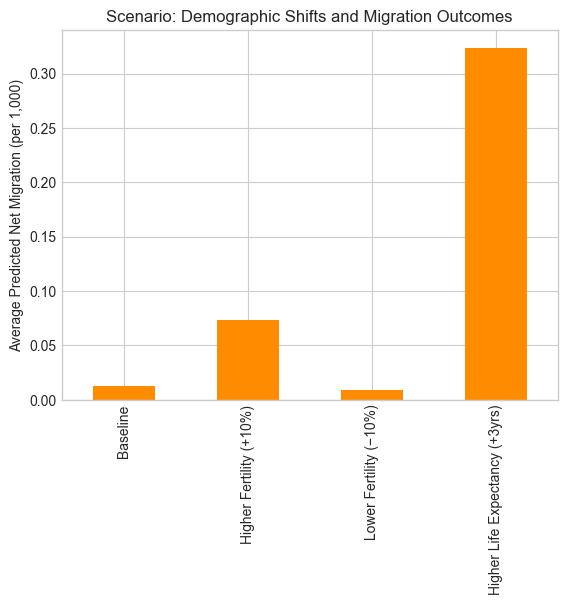

In [12]:
demo_scenarios = {
    "Baseline": X.copy(),
    "Higher Fertility (+10%)": X.assign(fertility_rate=X["fertility_rate"] * 1.10),
    "Lower Fertility (−10%)": X.assign(fertility_rate=X["fertility_rate"] * 0.90),
    "Higher Life Expectancy (+3yrs)": X.assign(life_expectancy=X["life_expectancy"] + 3)
}

demo_results = {}
for name, X_s in demo_scenarios.items():
    preds = model.predict(X_s)
    demo_results[name] = preds.mean()

pd.Series(demo_results).plot(kind="bar", color="darkorange")
plt.title("Scenario: Demographic Shifts and Migration Outcomes")
plt.ylabel("Average Predicted Net Migration (per 1,000)")
plt.show()


,Δ mean prediction (net migration per 1000 population)
High GDP Growth (+2pp),0.141787
Low GDP Growth (−2pp),-0.084594


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_45245/3420247713.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


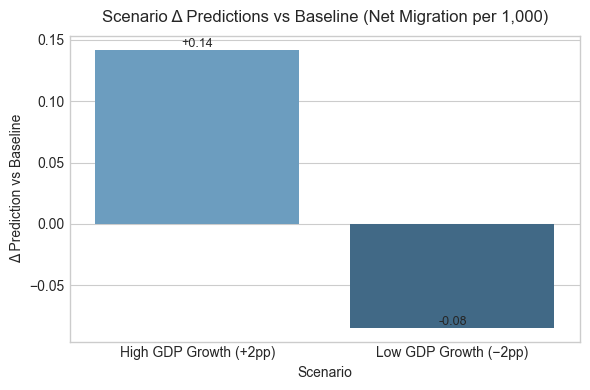

,High GDP Growth (+2pp),Low GDP Growth (−2pp)
Region,,
East Asia & Pacific,0.153001,-0.079838
Europe & Central Asia,0.004192,-0.135379
Latin America & Caribbean,0.026252,-0.011789
Middle East & North Africa,0.732723,-0.011530
North America,0.261533,-0.014198
South Asia,0.024642,-0.063178
Sub-Saharan Africa,0.048825,-0.116316


,High GDP Growth (+2pp),Low GDP Growth (−2pp)
Region,,
Middle East & North Africa,0.732723,-0.011530
North America,0.261533,-0.014198
East Asia & Pacific,0.153001,-0.079838
Sub-Saharan Africa,0.048825,-0.116316
Europe & Central Asia,0.004192,-0.135379
South Asia,0.024642,-0.063178
Latin America & Caribbean,0.026252,-0.011789



High GDP Growth (+2pp) — Top 10 increases:


,Country Name,year,delta
2856,Kuwait,1990,309.299877
4953,Syrian Arab Republic,2013,121.908910
4952,Syrian Arab Republic,2012,78.875812
5075,Timor-Leste,1999,31.645081
1009,Central African Republic,2013,12.445903
821,Burundi,1995,11.380706
173,Armenia,1993,7.671147
4955,Syrian Arab Republic,2015,6.172491
5357,United Arab Emirates,2009,5.606519
4626,"Somalia, Fed. Rep.",1992,5.184784


High GDP Growth (+2pp) — Top 10 decreases:


,Country Name,year,delta
35,Albania,1991,-68.965180
5635,"Yemen, Rep.",2015,-67.859497
3436,Moldova,1992,-37.221349
5336,Ukraine,2022,-36.657357
4966,Tajikistan,1992,-34.807780
4827,Sudan,2023,-8.551046
2009,Georgia,1993,-8.263298
3090,Libya,2020,-8.126651
1497,Djibouti,1991,-2.146797
4707,South Sudan,2005,-2.115572



Low GDP Growth (−2pp) — Top 10 increases:


,Country Name,year,delta
2856,Kuwait,1990,72.499426
4953,Syrian Arab Republic,2013,68.013669
4952,Syrian Arab Republic,2012,32.842852
5635,"Yemen, Rep.",2015,5.658083
17,Afghanistan,2007,4.430280
35,Albania,1991,2.984821
20,Afghanistan,2010,2.475039
1702,Eritrea,1992,2.208783
2737,Jordan,2007,2.029232
4292,Rwanda,1998,1.860421


Low GDP Growth (−2pp) — Top 10 decreases:


,Country Name,year,delta
105,Angola,1993,-93.573727
3084,Libya,2014,-60.319971
5308,Ukraine,1994,-39.965340
275,Azerbaijan,1993,-38.308711
4290,Rwanda,1996,-13.233048
888,Cambodia,1994,-9.155595
820,Burundi,1994,-9.067193
5078,Timor-Leste,2002,-8.127712
3,Afghanistan,1993,-7.300505
4714,South Sudan,2012,-7.006054


In [13]:
# Scenario Runner (Δ vs Baseline)
def run_scenarios(scenarios: dict):
    preds = {name: model.predict(df_) for name, df_ in scenarios.items()}
    base = preds["Baseline"]
    deltas = {
        name: pd.Series(pred - base, index=scenarios[name].index)
        for name, pred in preds.items()
        if name != "Baseline"
    }
    return preds, deltas

preds, deltas = run_scenarios(scenarios)

# Summary table of mean deltas
summary_global = pd.DataFrame(
    {k: v.mean() for k, v in deltas.items()},
    index=["Δ mean prediction (net migration per 1000 population)"]
).T
display(summary_global)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=summary_global.index,
    y=summary_global["Δ mean prediction (net migration per 1000 population)"],
    palette="Blues_d"
)
plt.title("Scenario Δ Predictions vs Baseline (Net Migration per 1,000)", pad=10)
plt.xlabel("Scenario")
plt.ylabel("Δ Prediction vs Baseline")
plt.tight_layout()
for i, v in enumerate(summary_global["Δ mean prediction (net migration per 1000 population)"]):
    plt.text(i, v, f"{v:+.2f}", ha='center', va='bottom', fontsize=9)
plt.show()

# Regional breakdown
if "Region" in df.columns:
    by_region = (
        pd.concat({k: v.groupby(df.loc[v.index, "Region"]).mean() for k, v in deltas.items()}, axis=1)
        .sort_index()
    )
    display(by_region)

# Sort regions by absolute average delta (strongest effects first)
by_region = by_region.reindex(
    by_region.abs().mean(axis=1).sort_values(ascending=False).index
)
display(by_region)

# Top movers (countries/rows)
for k, v in deltas.items():
    top_up = v.sort_values(ascending=False).head(10)
    top_down = v.sort_values().head(10)
    print(f"\n{k} — Top 10 increases:")
    display(df.loc[top_up.index, ["Country Name", "year"]].assign(delta=top_up.values))
    print(f"{k} — Top 10 decreases:")
    display(df.loc[top_down.index, ["Country Name", "year"]].assign(delta=top_down.values))


> 💡 *Note:* Δ mean prediction values are expressed in **net migration per 1,000 population**, consistent with the model’s target variable.  
> ⚠️ *Context:* Several large Δ values occur during early-1990s transition years (e.g., post-Soviet / Balkan states).  
> These correspond to historically volatile periods — interpret scenario deltas cautiously for those cases.  

## 6. Regional Insights Dashboard

> Aggregate SHAP impacts or predictions by region to highlight where model sensitivity is highest.    

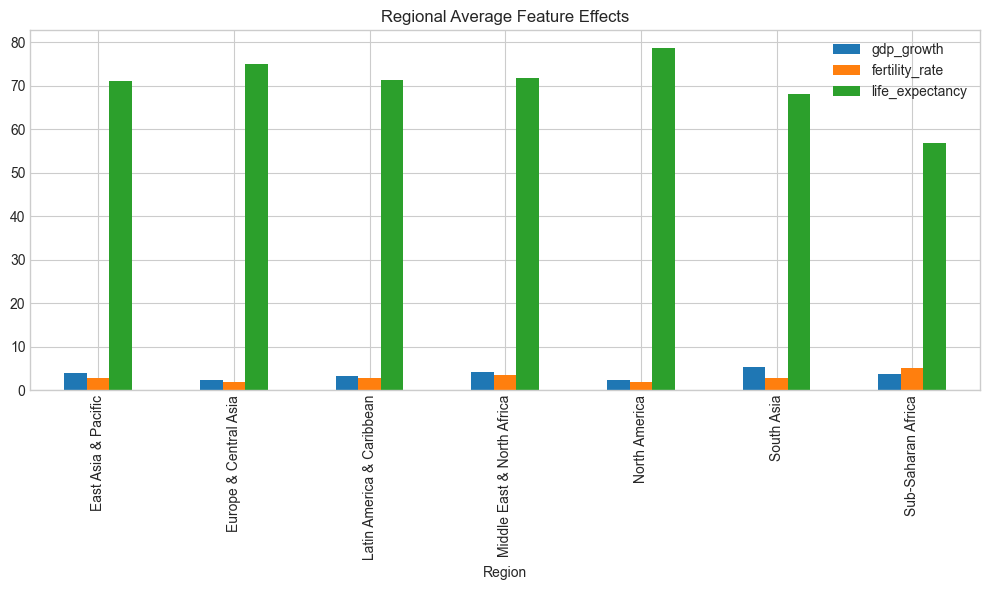

In [14]:
X["Region"] = df["Region"]
region_effects = X.groupby("Region")[["gdp_growth","fertility_rate","life_expectancy"]].mean()
region_effects.plot(kind="bar", figsize=(10,6))
plt.title("Regional Average Feature Effects")
plt.tight_layout(); plt.show()


## 🧭 7. Key Insights Summary

### **Global Drivers**
- **Economic performance** (GDP growth, per-capita income) is the strongest predictor of net migration.  
  Higher growth and stronger labor markets correspond to net inflows, while weak growth links to outflows.  
- **Demographics** also matter: larger populations and lower fertility rates tend to coincide with higher inflows, reflecting labor-demand dynamics.  
- **Unemployment** and **youth share** show negative SHAP directions, capturing push–pull effects linked to opportunity gaps.

### **Regional Patterns**
- **Europe & Central Asia** show the highest sensitivity to economic variables, especially GDP and unemployment.  
- **Sub-Saharan Africa** and **MENA** respond more to demographic features such as fertility and population growth.  
- **Latin America** and **East Asia** display balanced economic–demographic influences.

### **Scenario Simulations**
- A **+2 pp GDP growth shock** raises predicted migration by **≈ +0.14 per 1 000**, while **−2 pp** lowers it by **≈ −0.08 per 1 000**.  
- Regional deltas mirror SHAP patterns: high-income regions react more strongly, demographic-driven regions less.  
- SHAP insights thus align with scenario outcomes, confirming internal model coherence.

### **Implications**
- Economic shocks moderately shift predicted migration but structural factors dominate long-run trends.  
- Regional sensitivity can inform targeted policy (economic stabilization vs. demographic planning).  
- Estimates are **predictive, not causal**; adding uncertainty bands and temporal validation will enhance robustness.
